# Sequence-generating rate network

Dynamics:

$$\tau\frac{d\mathbf{h}}{dt} = -\mathbf{h} + J(t)\mathbf{r}$$

$$\mathbf{r} = \phi(\mathbf{h})$$

$$\phi(x) = \frac{1 + \tanh(\beta(x-\theta))}{2}$$

$$J = J^{FF}(t) + J^{INH}$$

where $J_{FF}$ is a feed-forward chain network with time-varying weights, i.e. 

$$J_{i,j}^{FF} = J_0(1 + w_iu(t))\delta_{i, j+1}$$

where $i,j$ can also be thought of as indexing link position in the chain.

$J^{INH}$ is a backwards inhibitory component (each neuron inhibits the neuron $\Delta_I$ steps to the left):

$$J_{i, j} = J_0^I\delta_{i, j-\Delta_I}$$

In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats

from disp import set_plot, get_line

cc = np.concatenate

DT = .001
N = 1000

RT = np.arange(0, 3., DT)
RX = np.arange(N, dtype=float)


def sgm(h):
    return (1 + np.tanh(h))/2

def plot_trj(ax, u_fn, w, t=None, xs=None, cscale=1, c_trj='k'):
    v_mat = 1 + u_fn(RT)[:, None]@w[None, :]
    ax.matshow(
        cscale*(v_mat.T-1), origin='lower', extent=[RT[0], RT[-1], RX[0], RX[-1]],
        vmin=-1, vmax=1, cmap='PuOr', zorder=0)  # pink = slow, g = fast, 1 = white
    
    if t is not None:
        [ax.plot(t, x, c=c_trj) for x in xs]
    
    ax.xaxis.tick_bottom()
    ax.set_aspect('auto')
    set_plot(ax, x_label='t', y_label='x')

In [2]:
P_0 = {
    'TAU': .05,
    'BETA': 10,
    'TH': 1,
    
    'J_0': 1,
    'J_INH': 0,
}

CXN_CHAIN = np.diag(np.ones(N-1), -1)

def smlt(t, w, u_fn, p, h_0=None):
    
    w_mat = np.diag(w[:-1], -1)
    TAU = p['TAU']
    
    phi = lambda h: sgm(p['BETA']*(h - p['TH']))
    
    J_0 = p['J_0']
    J_INH = p['J_INH']
    
    hs = np.nan*np.zeros((len(t), N))
    hs[0, :] = h_0 if h_0 is not None else 0
    
    rs = np.nan*np.zeros((len(t), N))
    rs[0, :] = phi(hs[0, :])
    
    u = np.nan*np.zeros(len(t))
    u[0] = u_fn(t[0])

    for ct, t_ in enumerate(t[1:], 1):
        
        u_ = u_fn(t_)
        u[ct] = u_
        
        J_FF = J_0*(CXN_CHAIN + w_mat*u_)
        
        J = J_FF + J_INH
        
        dh = (DT/TAU)*(-hs[ct-1, :] + J@rs[ct-1, :])
        
        hs[ct, :] = hs[ct-1, :] + dh
        rs[ct, :] = phi(hs[ct, :])
        
    return rs, hs, u

def get_x(rs):
    # estimate position by weighting nrn idxs w activity
    return (rs / rs.sum(axis=1)[:, None])@RX

def get_spd(x, t, mt):
    spd, icpt, _, _, _ = stats.linregress(t[mt], x[mt])
    return spd

# Unmodulated

Loop over J_0.

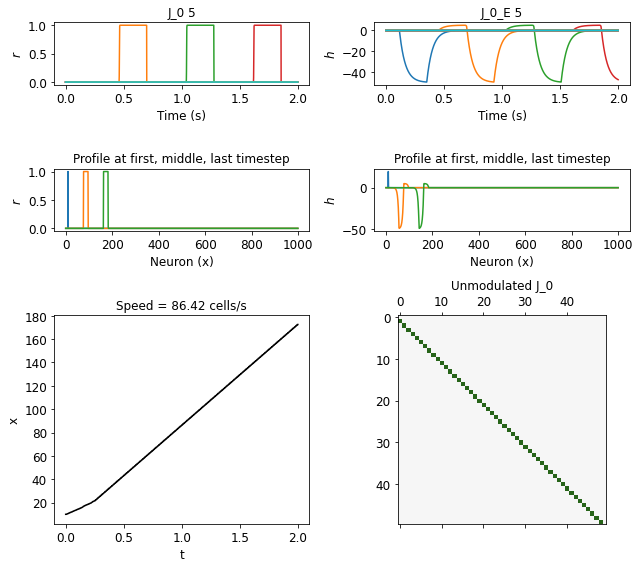

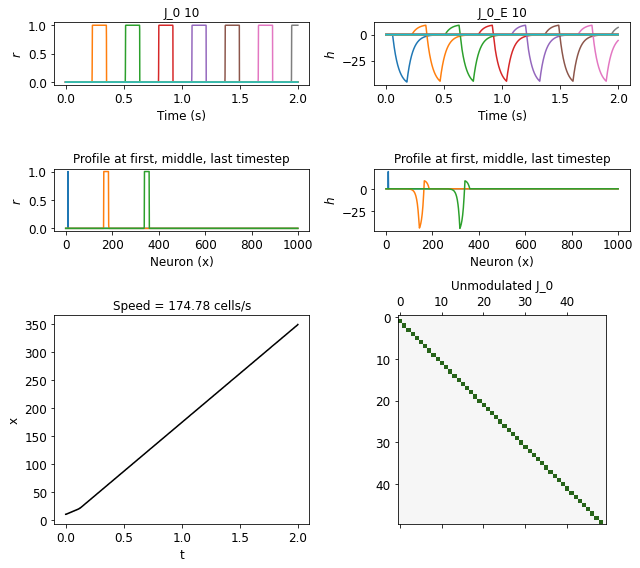

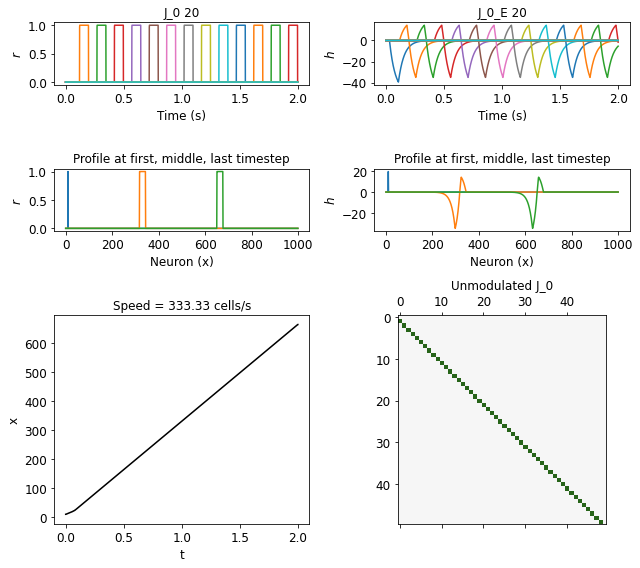

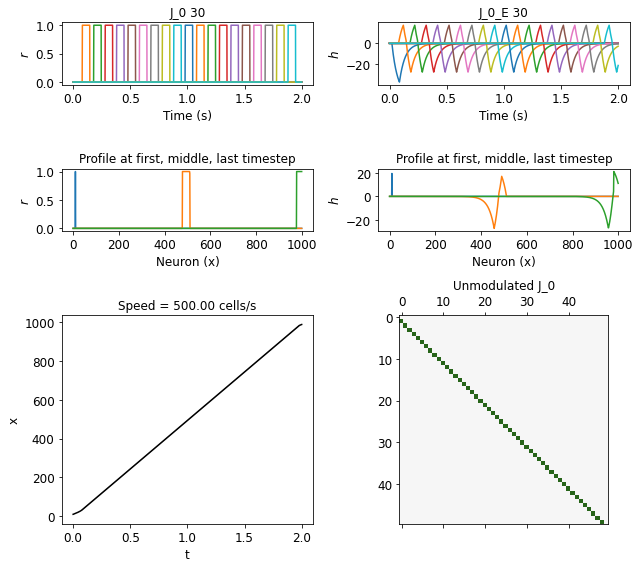

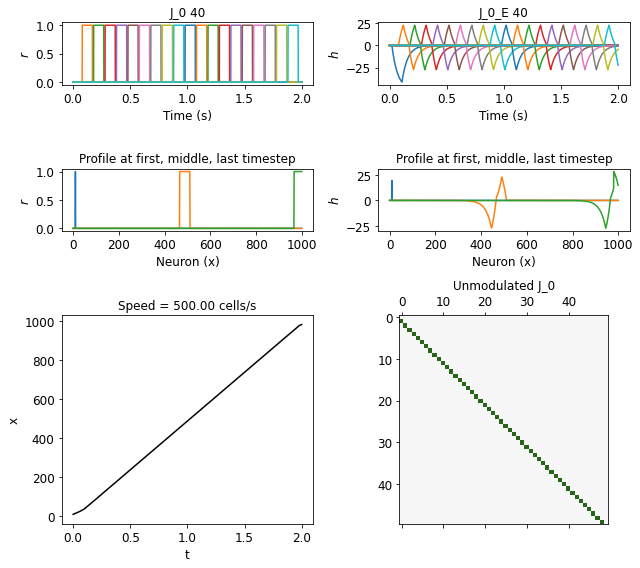

In [3]:
U_FN = lambda t_: 0
W = 0*np.ones(N)
J_0S = [5, 10, 20, 30, 40]

J_0_I = -50
INH_OFF = 20
J_INH = J_0_I*np.diag(np.ones(N-INH_OFF), INH_OFF)

PLOT_EVERY = 50

t = np.arange(0, 2, DT)
h_0 = 20*np.eye(N)[10, :]

mt_spd = (.5 <= t) & (t < 1.5)

for J_0 in J_0S:
    p = P_0.copy()

    # J_0           # exc feed-fwd chain             # backwards inhibition
    p['J_0'] = J_0
    p['J_INH'] = J_INH

    # run smln
    rs, hs, u = smlt(t, W, U_FN, p=p, h_0=h_0)

    x = get_x(rs)
    spd = get_spd(x, t, mt_spd)

    gs = gridspec.GridSpec(4, 2)
    fig = plt.figure(figsize=(9, 8), tight_layout=True)
    axs = [
        fig.add_subplot(gs[0, 0]),
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[1, 1]),
        fig.add_subplot(gs[2:, 0]),
        fig.add_subplot(gs[2:, 1]),
    ]
    axs[0].plot(t, rs[:, ::PLOT_EVERY])
    set_plot(axs[0], x_label='Time (s)', y_label=r'$r$', title=f'J_0 {J_0}')

    axs[1].plot(RX, rs[[1, len(t)//2, -1], :].T)
    set_plot(axs[1], x_label='Neuron (x)', y_label=r'$r$', title='Profile at first, middle, last timestep')

    axs[4].plot(t, x, c='k')
    set_plot(axs[4], x_label='t', y_label='x', title=f'Speed = {spd:.2f} cells/s')

    axs[2].plot(t, hs[:, ::PLOT_EVERY])
    set_plot(axs[2], x_label='Time (s)', y_label=r'$h$', title=f'J_0_E {J_0}')

    axs[3].plot(RX, hs[[1, len(t)//2, -1], :].T)
    set_plot(axs[3], x_label='Neuron (x)', y_label=r'$h$', title='Profile at first, middle, last timestep')

    axs[5].matshow((p['J_0']*CXN_CHAIN)[:50, :50], vmin=-1, vmax=1, cmap='PiYG')
    set_plot(axs[5], title='Unmodulated J_0')
    
    fig.savefig(f'ms/1s1_rate_speed_demo_j_0_{J_0}.svg')

# Speed vs $J_0$

In [4]:
U_FN = lambda t_: 0
W = 0*np.ones(N)
J_0S = np.linspace(5, 40, 25)

J_0_I = -50
INH_OFF = 20
J_INH = J_0_I*np.diag(np.ones(N-INH_OFF), INH_OFF)

PLOT_EVERY = 10

t = np.arange(0, 2, DT)
h_0 = 20*np.eye(N)[10, :]

mt_spd = (.5 <= t) & (t < 1.5)

spds = []

for J_0 in J_0S:
    p = P_0.copy()

    # J_0           # exc feed-fwd chain             # backwards inhibition
    p['J_0'] = J_0*np.diag(np.ones(N-1), -1)
    p['J_INH'] = J_INH

    # run smln
    rs, hs, u = smlt(t, W, U_FN, p=p, h_0=h_0)

    x = get_x(rs)
    spd = get_spd(x, t, mt_spd)
    
    spds.append(spd)

Speed approx 0.0155J_0 + 0.0171 units/ms


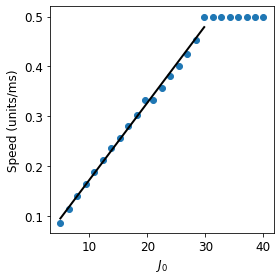

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
ax.scatter(J_0S, np.array(spds)/1000)
mask = J_0S < 30
x_line, y_line, (slp, icpt, _, _, _) = get_line(J_0S[mask], np.array(spds)[mask]/1000)
ax.plot(x_line, y_line, c='k', lw=2)
set_plot(ax, x_label=r'$J_0$', y_label='Speed (units/ms)')

print(f'Speed approx {slp:.4f}J_0 + ' + f'{icpt:.4f} units/ms')

fig.savefig('ms/1s1_speed_v_j_0_rate.svg')

# Demos with modulation

Temporally modulated

In [6]:
PER_T = .3
DUTY_T = 1/3
T_0 = .1

def U_FN(t_):
    sq_wv = signal.square((2*np.pi*(t_- T_0)/PER_T), duty=DUTY_T)
    return (sq_wv + 1)/2

W = -.5*np.ones(N)

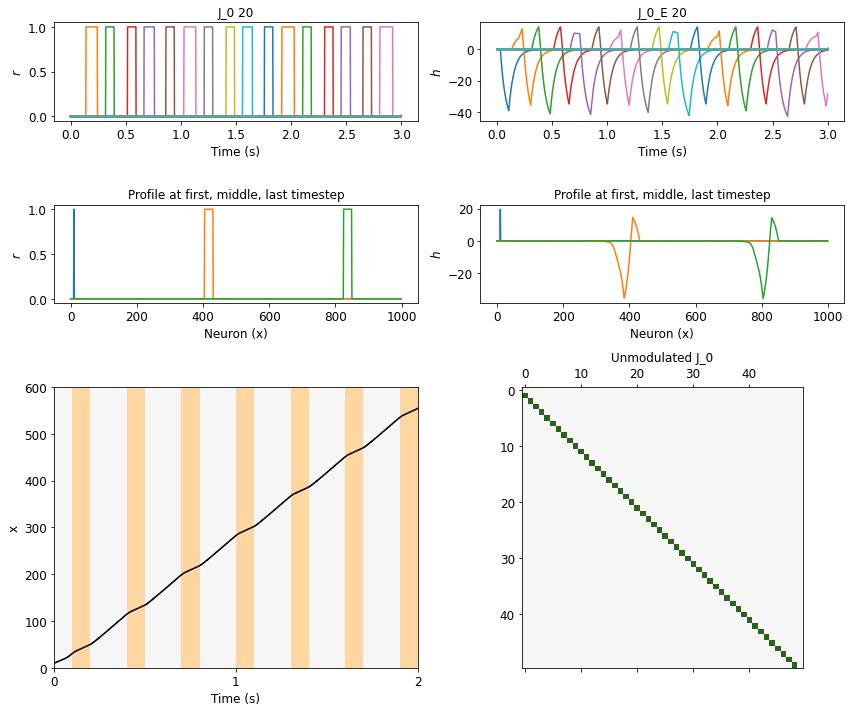

In [7]:
J_0 = 20

J_0_I = -50
INH_OFF = 20
J_INH = J_0_I*np.diag(np.ones(N-INH_OFF), INH_OFF)

PLOT_EVERY = 50

t = np.arange(0, 3, DT)
h_0 = 20*np.eye(N)[10, :]

# mt_spd = (.5 <= t) & (t < 1.5)

p = P_0.copy()

# J_0           # exc feed-fwd chain             # backwards inhibition
p['J_0'] = J_0  #*np.diag(np.ones(N-1), -1) +J_0_I*np.diag(np.ones(N-INH_OFF), INH_OFF)
p['J_INH'] = J_INH

# run smln
rs, hs, u = smlt(t, W, U_FN, p=p, h_0=h_0)

x = get_x(rs)
# spd = get_spd(x, t, mt_spd)

gs = gridspec.GridSpec(4, 2)
fig = plt.figure(figsize=(12, 10), tight_layout=True)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2:, 0]),
    fig.add_subplot(gs[2:, 1]),
]
axs[0].plot(t, rs[:, ::PLOT_EVERY])
set_plot(axs[0], x_label='Time (s)', y_label=r'$r$', title=f'J_0 {J_0}')

axs[1].plot(RX, rs[[1, len(t)//2, -1], :].T)
set_plot(axs[1], x_label='Neuron (x)', y_label=r'$r$', title='Profile at first, middle, last timestep')

plot_trj(axs[4], U_FN, W, t=t, xs=[x], cscale=.5, c_trj='k')
# axs[4].plot(t, x, c='k')
set_plot(axs[4], x_lim=(0, 2), y_lim=(0, 600), x_label='Time (s)', y_label='x')

axs[2].plot(t, hs[:, ::PLOT_EVERY])
set_plot(axs[2], x_label='Time (s)', y_label=r'$h$', title=f'J_0_E {J_0}')

axs[3].plot(RX, hs[[1, len(t)//2, -1], :].T)
set_plot(axs[3], x_label='Neuron (x)', y_label=r'$h$', title='Profile at first, middle, last timestep')

axs[5].matshow((p['J_0']*CXN_CHAIN)[:50, :50], vmin=-1, vmax=1, cmap='PiYG')
set_plot(axs[5], title='Unmodulated J_0')

Spatiotemporally modulated

In [8]:
PER_T = .7
DUTY_T = .5
T_0 = .1

PER_X = 200
DUTY_X = .4
# X_0 = 50
X_0 = 120

def U_FN(t_):
    sq_wv = signal.square((2*np.pi*(t_- T_0)/PER_T), duty=DUTY_T)
    return (sq_wv + 1)/2

W = -.5*(signal.square((2*np.pi*(RX - X_0)/PER_X), duty=DUTY_X)+1)/2
# -.5*np.ones(N)

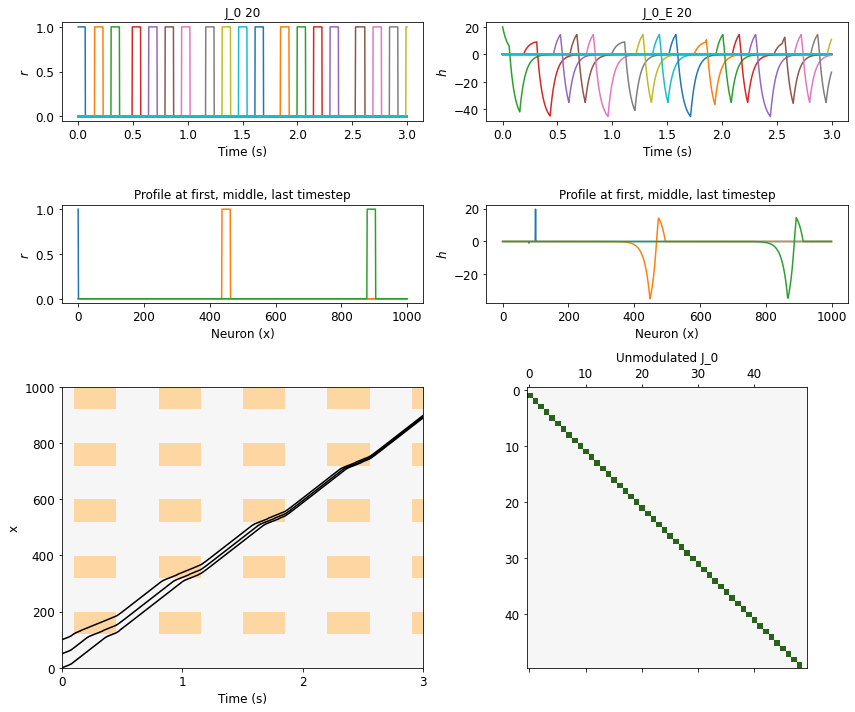

In [9]:
J_0 = 20

J_0_I = -50
INH_OFF = 20
J_INH = J_0_I*np.diag(np.ones(N-INH_OFF), INH_OFF)

PLOT_EVERY = 50

t = np.arange(0, 3, DT)
h_0s = [
    20*np.eye(N)[0, :],
    20*np.eye(N)[50, :],
    20*np.eye(N)[100, :],
]

# mt_spd = (.5 <= t) & (t < 1.5)

p = P_0.copy()

# J_0           # exc feed-fwd chain             # backwards inhibition
p['J_0'] = J_0  #*np.diag(np.ones(N-1), -1) +J_0_I*np.diag(np.ones(N-INH_OFF), INH_OFF)
p['J_INH'] = J_INH

# run smln
rs_all = []
x_all = []

for h_0 in h_0s:
    rs, hs, u = smlt(t, W, U_FN, p=p, h_0=h_0)
    x = get_x(rs)
    
    rs_all.append(rs)
    x_all.append(x)

# spd = get_spd(x, t, mt_spd)

gs = gridspec.GridSpec(4, 2)
fig = plt.figure(figsize=(12, 10), tight_layout=True)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2:, 0]),
    fig.add_subplot(gs[2:, 1]),
]
rs = rs_all[0]
axs[0].plot(t, rs[:, ::PLOT_EVERY])
set_plot(axs[0], x_label='Time (s)', y_label=r'$r$', title=f'J_0 {J_0}')

axs[1].plot(RX, rs[[1, len(t)//2, -1], :].T)
set_plot(axs[1], x_label='Neuron (x)', y_label=r'$r$', title='Profile at first, middle, last timestep')

plot_trj(axs[4], U_FN, W, t=t, xs=x_all, cscale=.5, c_trj='k')
set_plot(axs[4], x_lim=(0, 3), y_lim=(0, 1000), x_label='Time (s)', y_label='x')

axs[2].plot(t, hs[:, ::PLOT_EVERY])
set_plot(axs[2], x_label='Time (s)', y_label=r'$h$', title=f'J_0_E {J_0}')

axs[3].plot(RX, hs[[1, len(t)//2, -1], :].T)
set_plot(axs[3], x_label='Neuron (x)', y_label=r'$h$', title='Profile at first, middle, last timestep')

axs[5].matshow((p['J_0']*CXN_CHAIN)[:50, :50], vmin=-1, vmax=1, cmap='PiYG')
set_plot(axs[5], title='Unmodulated J_0')